In [1]:
# import packages
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
emo = emotioncon_modelling.Modelling()
prep = prep_emotioncon.PrepEmotioncon()
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
debug = True
data = np.load(filepath + 'results/fit_experiment.npy',allow_pickle='TRUE')
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


/Users/jolandamalamud/phd/papers/git_public/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [3]:
# make inputs ready
input_df = pd.read_csv(filepath + 'experiment/public/prep/videosForExperiment.csv')
inp_dummies = pd.get_dummies(input_df['category'])
inp_dummies = inp_dummies.reindex(columns=['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness'])
inp = inp_dummies.values
inp = np.vstack([np.zeros(np.shape(inp)[1]), inp, np.zeros(np.shape(inp)[1]), inp])

In [4]:
# define option for modelling
def define_kf_options(data, inp):
    options = {'cov': 'diagonal', 'inputs' : True, 'inp': inp}
    options['n_dim_obs'] = np.shape(data)[1]
    options['n_dim_state'] = options['n_dim_obs']
    options['n_dim_control'] = np.shape(inp)[1]
    options['maxiter'] = 100
    options['constraint control'] = False
    options['em_vars'] = ['transition_matrices', 'transition_offsets', 'control_matrix', \
                          'observation_covariance', 'transition_covariance']
    options['A'] = np.zeros((options['n_dim_state'],options['n_dim_state']))
    options['h'] = np.zeros(options['n_dim_state'])
    options['C'] = np.zeros((options['n_dim_state'],options['n_dim_control']))
    return options

Simulate data based on estimated parameters from the most parsimonious model
--

In [5]:
T = np.shape(data[0]['ratings'])[1]
nruns = 100
for sj in range(Nsj):
    z,x = np.empty((T,5,nruns)),np.empty((T,5,nruns))
    for t in range(2):
        inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
        for i in range(nruns):
            foo, x[t*int(T/2):t*int(T/2) + int(T/2),:,i] = \
            data[sj]['results_split'][13+t].sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                    control_inputs=inp_split)
            data[sj]['simulated'] = x

if debug == False:
    np.save(filepath + 'results/fit_experiment.npy', data)

Fit simulated data
--

In [9]:
nruns = data[0]['simulated'].shape[2]
for sj in range(Nsj):
    data[sj]['recovery'] = []
    for i in range(nruns):
        results = []
        data_to_fit = data[sj]['simulated'][:,:,i]
        T = np.shape(data_to_fit)[0]
        opt = define_kf_options(data_to_fit, inp)
        opt['em_vars'] = emo.parameter_short(['A', 'C', 'S', 'G'])
        ll_split = 0
        for t in range(2):
            mood_ratings_split = data_to_fit[t*int(T/2):t*int(T/2) + int(T/2),:]
            inputs_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
            opt['inp'] = inputs_split 
            kf = emo.run_KF(mood_ratings_split, opt)
            results.append(kf)
    
        data[sj]['recovery'].append(results)

if debug == False:
    np.save(filepath + 'results/fit_experiment.npy', data)

In [14]:
cc=[]
true,est = np.empty([2*Nsj,5,5]),np.empty([2*Nsj,5,5])
ccc=[]
truec,estc = np.empty([2*Nsj,5,5]),np.empty([2*Nsj,5,5])
for i in range(2):
    for sj in range(Nsj):
        cc.append(np.corrcoef(dynamics['matrix'][:,:,sj,i].flatten(), \
                              data[sj]['recovery'][i].transition_matrices.flatten())[0,1])
        true[sj+i*Nsj,:,:] = dynamics['matrix'][:,:,sj,i]
        est[sj+i*Nsj,:,:] = data[sj]['recovery'][i].transition_matrices
        ccc.append(np.corrcoef(controls['matrix'][:,:,sj,i].flatten(), \
                              data[sj]['recovery'][i].control_matrix.flatten())[0,1])
        truec[sj+i*Nsj,:,:] = controls['matrix'][:,:,sj,i]
        estc[sj+i*Nsj,:,:] = data[sj]['recovery'][i].control_matrix

AttributeError: 'list' object has no attribute 'transition_matrices'

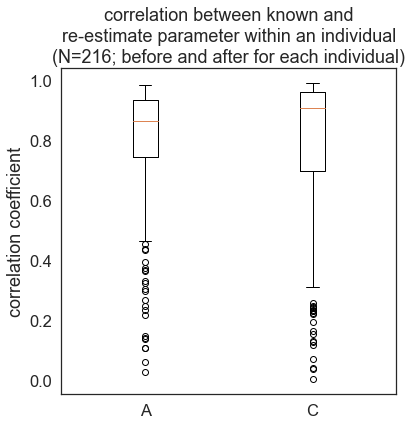

In [11]:
ex = ~np.isin(np.arange(2*len(df)), [18,40,18+len(df),40+len(df)])
plt.figure(figsize=(6,6))
plt.boxplot(np.array([np.abs(cc)[ex],np.abs(ccc)[ex]]).T);
plt.xticks([1,2],['A','C']);
plt.ylabel('correlation coefficient');
plt.title('correlation between known and\nre-estimate parameter within an individual\n' + \
         '(N=' + str(len(cc)) + '; before and after for each individual)');
plt.savefig('/Users/jolandamalamud/Desktop/corr_AC.png')

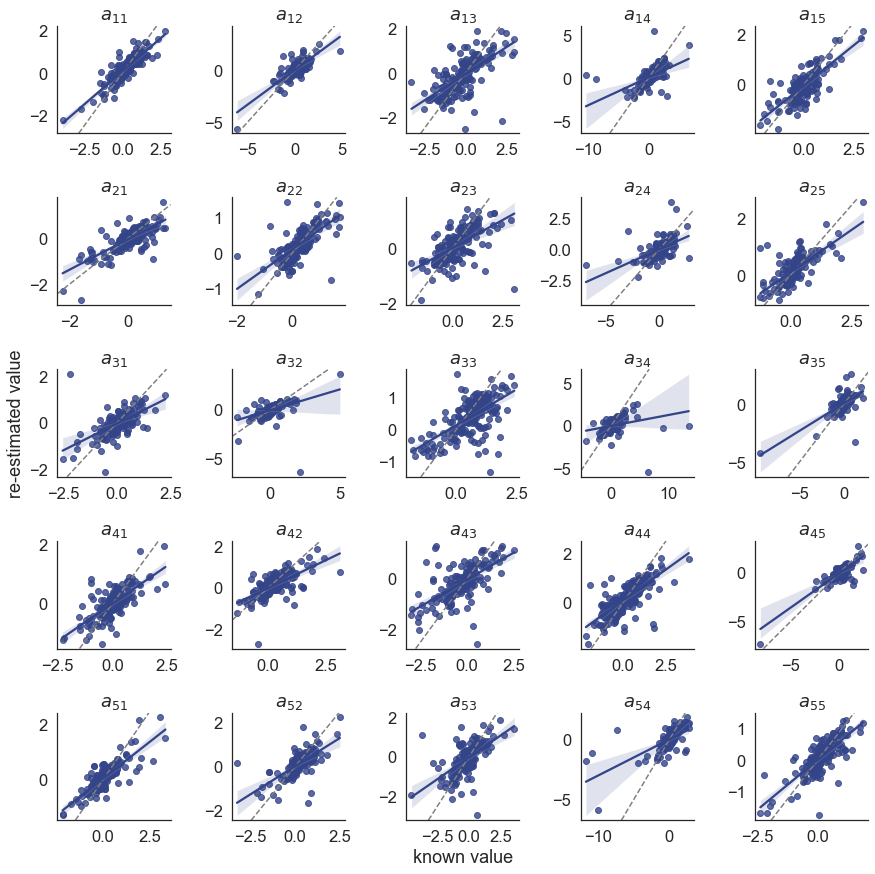

In [25]:
df_rec=pd.DataFrame(columns=['known value','re-estimated value'])
df_rec['known value'] = true[ex,:,:].flatten()
df_rec['re-estimated value'] = est[ex,:,:].flatten()
df_rec['id'] = np.repeat(np.arange(sum(ex)),25)
df_rec['x'] = np.tile(np.repeat(np.arange(5),5), sum(ex)) 
df_rec['y'] = np.tile(np.arange(5), sum(ex)*5)
with sns.axes_style("white"):
    g = sns.FacetGrid(df_rec, row="x", col="y", sharex=False, sharey=False, height=2.5);
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, linestyle='--', color='gray')
g.map(sns.regplot, "known value", "re-estimated value", color="#334488");
k=0
for ax, title in zip(g.axes.flatten(),['$a_{' + str(i) + str(j) + '}$' for i in range(1,6) for j in range(1,6)]):
    ax.set_title(title)
    if k == 10: ax.set_ylabel('re-estimated value')
    else: ax.set_ylabel('')
    if k == 22: ax.set_xlabel('known value')
    else: ax.set_xlabel('')
    k += 1
plt.savefig('/Users/jolandamalamud/Desktop/corr_A.png')

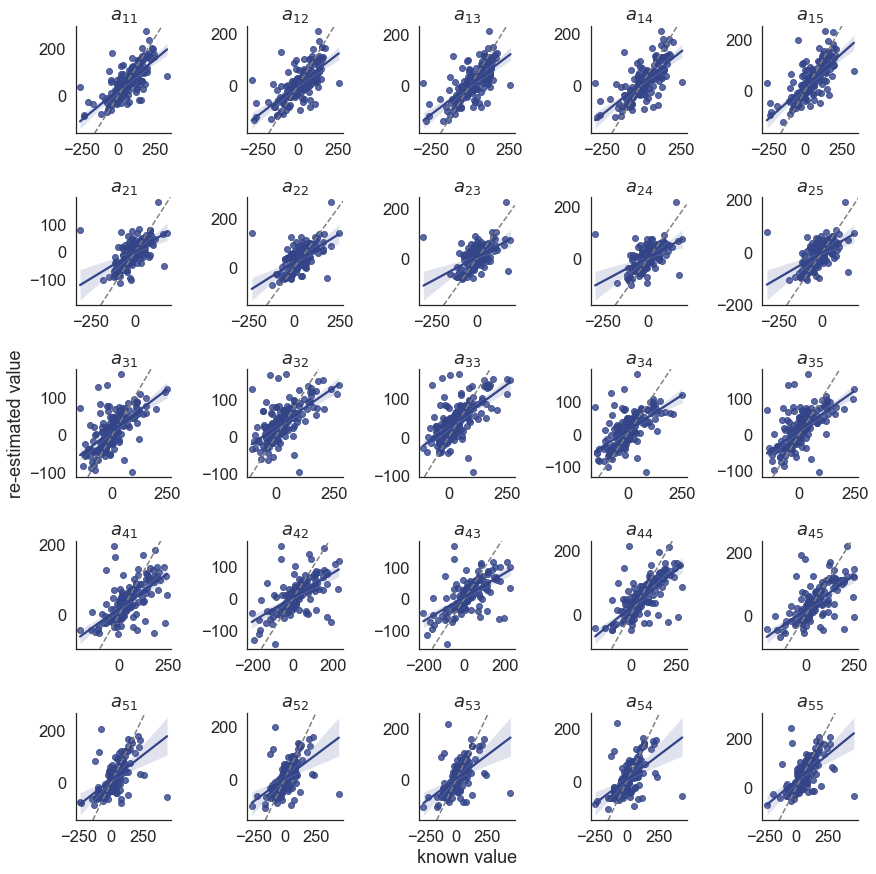

In [26]:
df_rec=pd.DataFrame(columns=['known value','re-estimated value'])
df_rec['known value'] = truec[ex,:,:].flatten()
df_rec['re-estimated value'] = estc[ex,:,:].flatten()
df_rec['id'] = np.repeat(np.arange(sum(ex)),25)
df_rec['x'] = np.tile(np.repeat(np.arange(5),5), sum(ex)) 
df_rec['y'] = np.tile(np.arange(5), sum(ex)*5)
with sns.axes_style("white"):
    g = sns.FacetGrid(df_rec, row="x", col="y", sharex=False, sharey=False, height=2.5);
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, linestyle='--', color='gray')
g.map(sns.regplot, "known value", "re-estimated value", color="#334488");
for ax, title in zip(g.axes.flatten(),['$c_{' + str(i) + str(j) + '}$' for i in range(1,6) for j in range(1,6)]):
    ax.set_title(title)
k=0
for ax, title in zip(g.axes.flatten(),['$a_{' + str(i) + str(j) + '}$' for i in range(1,6) for j in range(1,6)]):
    ax.set_title(title)
    if k == 10: ax.set_ylabel('re-estimated value')
    else: ax.set_ylabel('')
    if k == 22: ax.set_xlabel('known value')
    else: ax.set_xlabel('')
    k += 1
plt.savefig('/Users/jolandamalamud/Desktop/corr_C.png')